In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 525], examples_per_second: 831.3932, train_label_loss: 2.7863, 


epoch: 1, [batch: 53 / 525], examples_per_second: 11655.7526, train_label_loss: 2.6625, 


epoch: 1, [batch: 105 / 525], examples_per_second: 11800.4779, train_label_loss: 2.4221, 


epoch: 1, [batch: 158 / 525], examples_per_second: 11634.0001, train_label_loss: 2.2648, 


epoch: 1, [batch: 210 / 525], examples_per_second: 11689.2564, train_label_loss: 2.0916, 


epoch: 1, [batch: 263 / 525], examples_per_second: 11582.1409, train_label_loss: 2.0273, 


epoch: 1, [batch: 315 / 525], examples_per_second: 11586.6194, train_label_loss: 1.7802, 


epoch: 1, [batch: 367 / 525], examples_per_second: 11693.0214, train_label_loss: 1.5246, 


epoch: 1, [batch: 420 / 525], examples_per_second: 11725.7194, train_label_loss: 1.4469, 


epoch: 1, [batch: 472 / 525], examples_per_second: 11648.5159, train_label_loss: 1.4051, 


epoch: 1, source_val_acc_label: 0.7297, source_val_label_loss: 1.2477, target_val_acc_label: 0.0626, target_val_label_loss: 5.9402, 


New best
epoch: 2, [batch: 1 / 525], examples_per_second: 111.5630, train_label_loss: 1.2325, 


epoch: 2, [batch: 53 / 525], examples_per_second: 11565.3601, train_label_loss: 1.1436, 


epoch: 2, [batch: 105 / 525], examples_per_second: 11732.3041, train_label_loss: 0.9922, 


epoch: 2, [batch: 158 / 525], examples_per_second: 11790.5648, train_label_loss: 0.9467, 


epoch: 2, [batch: 210 / 525], examples_per_second: 11694.0549, train_label_loss: 0.9715, 


epoch: 2, [batch: 263 / 525], examples_per_second: 11786.5404, train_label_loss: 0.9280, 


epoch: 2, [batch: 315 / 525], examples_per_second: 11711.7355, train_label_loss: 0.7887, 


epoch: 2, [batch: 367 / 525], examples_per_second: 11651.0098, train_label_loss: 0.6821, 


epoch: 2, [batch: 420 / 525], examples_per_second: 11597.7763, train_label_loss: 0.6668, 


epoch: 2, [batch: 472 / 525], examples_per_second: 12069.4699, train_label_loss: 0.8169, 


epoch: 2, source_val_acc_label: 0.8782, source_val_label_loss: 0.6432, target_val_acc_label: 0.0575, target_val_label_loss: 13.8250, 


epoch: 3, [batch: 1 / 525], examples_per_second: 139.8135, train_label_loss: 0.6187, 


epoch: 3, [batch: 53 / 525], examples_per_second: 11533.7195, train_label_loss: 0.6932, 


epoch: 3, [batch: 105 / 525], examples_per_second: 11581.3177, train_label_loss: 0.4817, 


epoch: 3, [batch: 158 / 525], examples_per_second: 11698.6163, train_label_loss: 0.4858, 


epoch: 3, [batch: 210 / 525], examples_per_second: 11549.3175, train_label_loss: 0.4608, 


epoch: 3, [batch: 263 / 525], examples_per_second: 11586.6591, train_label_loss: 0.4754, 


epoch: 3, [batch: 315 / 525], examples_per_second: 11721.9247, train_label_loss: 0.4789, 


epoch: 3, [batch: 367 / 525], examples_per_second: 11729.5338, train_label_loss: 0.4203, 


epoch: 3, [batch: 420 / 525], examples_per_second: 11609.6916, train_label_loss: 0.3693, 


epoch: 3, [batch: 472 / 525], examples_per_second: 11645.3721, train_label_loss: 0.5988, 


epoch: 3, source_val_acc_label: 0.9279, source_val_label_loss: 0.3912, target_val_acc_label: 0.0720, target_val_label_loss: 10.1310, 


New best
epoch: 4, [batch: 1 / 525], examples_per_second: 135.2741, train_label_loss: 0.3781, 


epoch: 4, [batch: 53 / 525], examples_per_second: 11414.2807, train_label_loss: 0.3265, 


epoch: 4, [batch: 105 / 525], examples_per_second: 11650.3582, train_label_loss: 0.3769, 


epoch: 4, [batch: 158 / 525], examples_per_second: 11764.4552, train_label_loss: 0.3605, 


epoch: 4, [batch: 210 / 525], examples_per_second: 11615.2738, train_label_loss: 0.3929, 


epoch: 4, [batch: 263 / 525], examples_per_second: 11663.2850, train_label_loss: 0.4245, 


epoch: 4, [batch: 315 / 525], examples_per_second: 11667.8874, train_label_loss: 0.3456, 


epoch: 4, [batch: 367 / 525], examples_per_second: 11784.9856, train_label_loss: 0.2868, 


epoch: 4, [batch: 420 / 525], examples_per_second: 11559.5697, train_label_loss: 0.3399, 


epoch: 4, [batch: 472 / 525], examples_per_second: 11564.0427, train_label_loss: 0.3537, 


epoch: 4, source_val_acc_label: 0.9170, source_val_label_loss: 0.3311, target_val_acc_label: 0.0679, target_val_label_loss: 16.2222, 


epoch: 5, [batch: 1 / 525], examples_per_second: 136.5113, train_label_loss: 0.2953, 


epoch: 5, [batch: 53 / 525], examples_per_second: 11583.3455, train_label_loss: 0.2242, 


epoch: 5, [batch: 105 / 525], examples_per_second: 11625.6685, train_label_loss: 0.2936, 


epoch: 5, [batch: 158 / 525], examples_per_second: 11701.8782, train_label_loss: 0.3435, 


epoch: 5, [batch: 210 / 525], examples_per_second: 11608.2128, train_label_loss: 0.2317, 


epoch: 5, [batch: 263 / 525], examples_per_second: 11812.2825, train_label_loss: 0.2563, 


epoch: 5, [batch: 315 / 525], examples_per_second: 11613.8097, train_label_loss: 0.2472, 


epoch: 5, [batch: 367 / 525], examples_per_second: 11594.5305, train_label_loss: 0.2462, 


epoch: 5, [batch: 420 / 525], examples_per_second: 11680.7705, train_label_loss: 0.2664, 


epoch: 5, [batch: 472 / 525], examples_per_second: 11852.5519, train_label_loss: 0.2470, 


epoch: 5, source_val_acc_label: 0.9533, source_val_label_loss: 0.2302, target_val_acc_label: 0.0717, target_val_label_loss: 16.4655, 


epoch: 6, [batch: 1 / 525], examples_per_second: 149.6736, train_label_loss: 0.2578, 


epoch: 6, [batch: 53 / 525], examples_per_second: 12526.2259, train_label_loss: 0.1616, 


epoch: 6, [batch: 105 / 525], examples_per_second: 12755.2788, train_label_loss: 0.2087, 


epoch: 6, [batch: 158 / 525], examples_per_second: 10820.8243, train_label_loss: 0.1910, 


epoch: 6, [batch: 210 / 525], examples_per_second: 10697.6395, train_label_loss: 0.2204, 


epoch: 6, [batch: 263 / 525], examples_per_second: 10616.5577, train_label_loss: 0.1589, 


epoch: 6, [batch: 315 / 525], examples_per_second: 10686.1985, train_label_loss: 0.3094, 


epoch: 6, [batch: 367 / 525], examples_per_second: 10843.6442, train_label_loss: 0.1928, 


epoch: 6, [batch: 420 / 525], examples_per_second: 10555.7400, train_label_loss: 0.1616, 


epoch: 6, [batch: 472 / 525], examples_per_second: 10523.1785, train_label_loss: 0.2357, 


epoch: 6, source_val_acc_label: 0.9363, source_val_label_loss: 0.2653, target_val_acc_label: 0.0809, target_val_label_loss: 26.6323, 


New best
epoch: 7, [batch: 1 / 525], examples_per_second: 119.5914, train_label_loss: 0.1564, 


epoch: 7, [batch: 53 / 525], examples_per_second: 10514.9423, train_label_loss: 0.2026, 


epoch: 7, [batch: 105 / 525], examples_per_second: 10717.3479, train_label_loss: 0.3106, 


epoch: 7, [batch: 158 / 525], examples_per_second: 10751.5413, train_label_loss: 0.1738, 


epoch: 7, [batch: 210 / 525], examples_per_second: 10734.8089, train_label_loss: 0.1794, 


epoch: 7, [batch: 263 / 525], examples_per_second: 10762.2160, train_label_loss: 0.1721, 


epoch: 7, [batch: 315 / 525], examples_per_second: 10749.0396, train_label_loss: 0.1718, 


epoch: 7, [batch: 367 / 525], examples_per_second: 10778.5883, train_label_loss: 0.2041, 


epoch: 7, [batch: 420 / 525], examples_per_second: 10769.2791, train_label_loss: 0.1761, 


epoch: 7, [batch: 472 / 525], examples_per_second: 10731.0828, train_label_loss: 0.1603, 


epoch: 7, source_val_acc_label: 0.9134, source_val_label_loss: 0.2907, target_val_acc_label: 0.0703, target_val_label_loss: 47.5823, 


epoch: 8, [batch: 1 / 525], examples_per_second: 122.3234, train_label_loss: 0.1821, 


epoch: 8, [batch: 53 / 525], examples_per_second: 10703.3651, train_label_loss: 0.2604, 


epoch: 8, [batch: 105 / 525], examples_per_second: 10699.4352, train_label_loss: 0.1956, 


epoch: 8, [batch: 158 / 525], examples_per_second: 10657.5629, train_label_loss: 0.1415, 


epoch: 8, [batch: 210 / 525], examples_per_second: 10765.6864, train_label_loss: 0.1478, 


epoch: 8, [batch: 263 / 525], examples_per_second: 10668.5557, train_label_loss: 0.1828, 


epoch: 8, [batch: 315 / 525], examples_per_second: 10574.9184, train_label_loss: 0.2436, 


epoch: 8, [batch: 367 / 525], examples_per_second: 10758.5754, train_label_loss: 0.1567, 


epoch: 8, [batch: 420 / 525], examples_per_second: 10771.8434, train_label_loss: 0.1897, 


epoch: 8, [batch: 472 / 525], examples_per_second: 10707.7536, train_label_loss: 0.2973, 


epoch: 8, source_val_acc_label: 0.9527, source_val_label_loss: 0.2419, target_val_acc_label: 0.0788, target_val_label_loss: 19.0203, 


epoch: 9, [batch: 1 / 525], examples_per_second: 125.3413, train_label_loss: 0.1686, 


epoch: 9, [batch: 53 / 525], examples_per_second: 10680.8631, train_label_loss: 0.1583, 


epoch: 9, [batch: 105 / 525], examples_per_second: 10742.9715, train_label_loss: 0.1165, 


epoch: 9, [batch: 158 / 525], examples_per_second: 10574.9236, train_label_loss: 0.1427, 


epoch: 9, [batch: 210 / 525], examples_per_second: 10724.2522, train_label_loss: 0.1774, 


epoch: 9, [batch: 263 / 525], examples_per_second: 10648.1546, train_label_loss: 0.1211, 


epoch: 9, [batch: 315 / 525], examples_per_second: 10753.8427, train_label_loss: 0.1046, 


epoch: 9, [batch: 367 / 525], examples_per_second: 10762.5986, train_label_loss: 0.1187, 


epoch: 9, [batch: 420 / 525], examples_per_second: 10753.6339, train_label_loss: 0.1035, 


epoch: 9, [batch: 472 / 525], examples_per_second: 10759.0439, train_label_loss: 0.1650, 


epoch: 9, source_val_acc_label: 0.9408, source_val_label_loss: 0.2061, target_val_acc_label: 0.0822, target_val_label_loss: 60.0768, 


New best
epoch: 10, [batch: 1 / 525], examples_per_second: 125.5662, train_label_loss: 0.2531, 


epoch: 10, [batch: 53 / 525], examples_per_second: 10730.6497, train_label_loss: 0.1764, 


epoch: 10, [batch: 105 / 525], examples_per_second: 10977.8673, train_label_loss: 0.1643, 


epoch: 10, [batch: 158 / 525], examples_per_second: 11808.1648, train_label_loss: 0.1186, 


epoch: 10, [batch: 210 / 525], examples_per_second: 11792.5673, train_label_loss: 0.1299, 


epoch: 10, [batch: 263 / 525], examples_per_second: 11742.7239, train_label_loss: 0.1868, 


epoch: 10, [batch: 315 / 525], examples_per_second: 11923.7232, train_label_loss: 0.0924, 


epoch: 10, [batch: 367 / 525], examples_per_second: 11787.8668, train_label_loss: 0.0864, 


epoch: 10, [batch: 420 / 525], examples_per_second: 11659.2945, train_label_loss: 0.1335, 


epoch: 10, [batch: 472 / 525], examples_per_second: 11915.5855, train_label_loss: 0.1469, 


epoch: 10, source_val_acc_label: 0.9566, source_val_label_loss: 0.1719, target_val_acc_label: 0.0670, target_val_label_loss: 45.5581, 


epoch: 11, [batch: 1 / 525], examples_per_second: 138.0525, train_label_loss: 0.1030, 


epoch: 11, [batch: 53 / 525], examples_per_second: 11455.4456, train_label_loss: 0.1272, 


epoch: 11, [batch: 105 / 525], examples_per_second: 11760.2774, train_label_loss: 0.1313, 


epoch: 11, [batch: 158 / 525], examples_per_second: 11826.9725, train_label_loss: 0.1542, 


epoch: 11, [batch: 210 / 525], examples_per_second: 11710.1095, train_label_loss: 0.1050, 


epoch: 11, [batch: 263 / 525], examples_per_second: 11636.3600, train_label_loss: 0.1587, 


epoch: 11, [batch: 315 / 525], examples_per_second: 11735.5838, train_label_loss: 0.1153, 


epoch: 11, [batch: 367 / 525], examples_per_second: 11717.2164, train_label_loss: 0.0916, 


epoch: 11, [batch: 420 / 525], examples_per_second: 11800.0653, train_label_loss: 0.1525, 


epoch: 11, [batch: 472 / 525], examples_per_second: 11744.4112, train_label_loss: 0.2207, 


epoch: 11, source_val_acc_label: 0.9524, source_val_label_loss: 0.2343, target_val_acc_label: 0.0662, target_val_label_loss: 43.8728, 


epoch: 12, [batch: 1 / 525], examples_per_second: 141.2532, train_label_loss: 0.0798, 


epoch: 12, [batch: 53 / 525], examples_per_second: 12131.8746, train_label_loss: 0.0900, 


epoch: 12, [batch: 105 / 525], examples_per_second: 12557.6382, train_label_loss: 0.1405, 


epoch: 12, [batch: 158 / 525], examples_per_second: 11676.3894, train_label_loss: 0.1420, 


epoch: 12, [batch: 210 / 525], examples_per_second: 11767.1577, train_label_loss: 0.1258, 


epoch: 12, [batch: 263 / 525], examples_per_second: 11783.8362, train_label_loss: 0.1008, 


epoch: 12, [batch: 315 / 525], examples_per_second: 11653.6263, train_label_loss: 0.1116, 


epoch: 12, [batch: 367 / 525], examples_per_second: 11776.2164, train_label_loss: 0.1875, 


epoch: 12, [batch: 420 / 525], examples_per_second: 11798.9448, train_label_loss: 0.1279, 


epoch: 12, [batch: 472 / 525], examples_per_second: 11739.3244, train_label_loss: 0.1228, 


epoch: 12, source_val_acc_label: 0.9526, source_val_label_loss: 0.2342, target_val_acc_label: 0.0795, target_val_label_loss: 40.6934, 


epoch: 13, [batch: 1 / 525], examples_per_second: 140.9175, train_label_loss: 0.1284, 


epoch: 13, [batch: 53 / 525], examples_per_second: 11664.8355, train_label_loss: 0.0994, 


epoch: 13, [batch: 105 / 525], examples_per_second: 11760.7382, train_label_loss: 0.1066, 


epoch: 13, [batch: 158 / 525], examples_per_second: 11684.4927, train_label_loss: 0.2456, 


epoch: 13, [batch: 210 / 525], examples_per_second: 11736.1068, train_label_loss: 0.0901, 


epoch: 13, [batch: 263 / 525], examples_per_second: 11798.9791, train_label_loss: 0.1939, 


epoch: 13, [batch: 315 / 525], examples_per_second: 11765.6005, train_label_loss: 0.1507, 


epoch: 13, [batch: 367 / 525], examples_per_second: 11782.0511, train_label_loss: 0.1530, 


epoch: 13, [batch: 420 / 525], examples_per_second: 11800.6134, train_label_loss: 0.1561, 


epoch: 13, [batch: 472 / 525], examples_per_second: 11854.0668, train_label_loss: 0.1006, 


epoch: 13, source_val_acc_label: 0.9617, source_val_label_loss: 0.1726, target_val_acc_label: 0.0780, target_val_label_loss: 25.2539, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

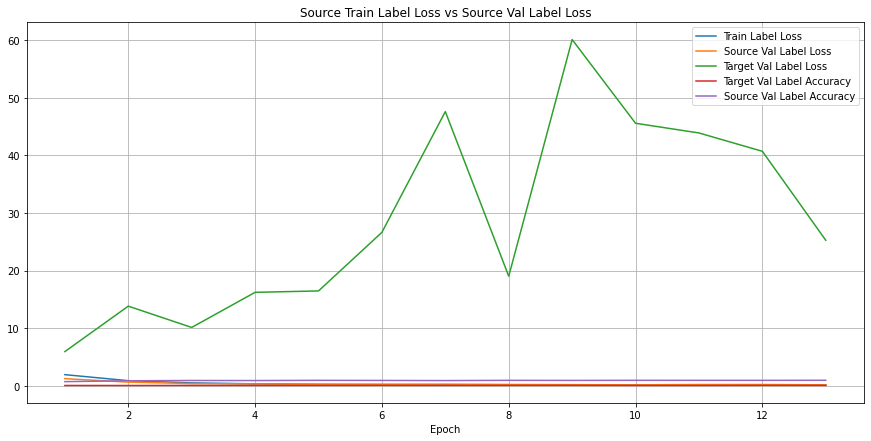

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

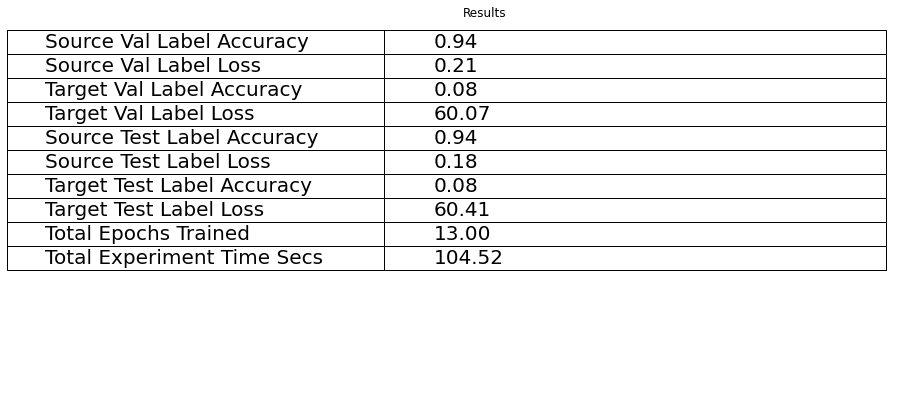

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

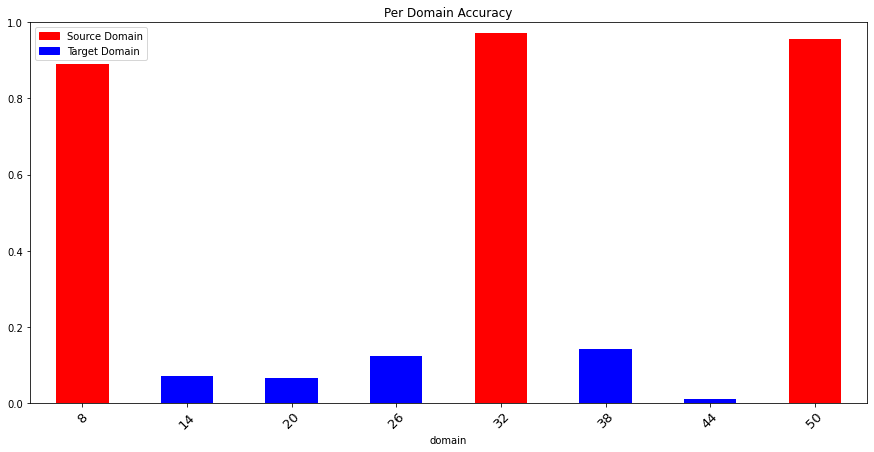

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9391666666666667 Target Test Label Accuracy: 0.08383333333333333
Source Val Label Accuracy: 0.9407638888888888 Target Val Label Accuracy: 0.08216666666666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:oracle.run2.framed", "parameters": {"experiment_name": "cnn_1:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1